 ### Данные разбиты на два файла "fraud_profile.csv" и "fraud_behavior.csv" здесь мы рассмотрим только первый.

## Описание данных:

#### fraud_profile.csv содержит данные о регистрации и профиле пользователя.

* user: уникальный user_id-s
* мошенничество: зависимая переменная (1 - мошенничество, 0 - не мошенничество)
* email_domain: зашифрованный домен электронной почты.
* ip_asn: кодированный ASN регистрации.
* signup_datetime: время регистрации пользователя.
* пол: кодированный пол пользователя.
* marital: семейное положение пользователя.
* занятость: закодированный статус занятости пользователя.
* pet: список домашних животных пользователя.


In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('fraud_profile.csv')
data.head(3)

,user,fraud,email_domain,ip_asn,signup_datetime,gender,marital,employment,pet
0,1000000,0,c,11202,2020-05-03 17:29:33,1.0,Married,i,['No pets']
1,1000015,0,f,11202,2020-05-03 17:32:33,1.0,Married,d,['Cat']
2,1000019,0,c,11202,2020-05-03 17:33:52,1.0,Single,f,['No pets']


In [11]:
print(f'Shape of profile data - {data.shape}')

Shape of profile data - (70283, 9)


In [12]:
print(f'Number of duplicates - {data.duplicated().sum()}')

Number of duplicates - 4


In [13]:
data.drop_duplicates(ignore_index=True, inplace=True)

### fraud (целевая функция)
#### Это целевая переменная, которую нам нужно предсказать. Посмотрим на распределение.

Is Fraud - 11.34%
Not Fraud - 88.66%


<AxesSubplot:xlabel='fraud', ylabel='count'>

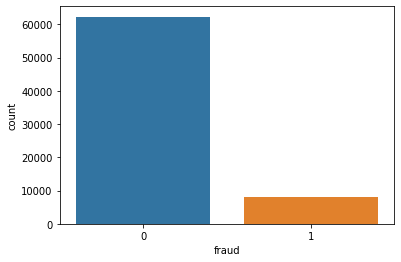

In [14]:
p = round(data.fraud.mean()*100, 2)
print(f'Is Fraud - {p}%')
print(f'Not Fraud - {100-p}%')
sns.countplot(data.fraud)

#### Как и ожидалось, мы видим, что этот класс сильно разбалансирован. Здесь 88.66% наблюдений не являются мошенничеством, а остальные 11.34% являются мошенническими.

In [15]:
data.isna().sum()

user                 0
fraud                0
email_domain         0
ip_asn               0
signup_datetime      0
gender             262
marital              1
employment          11
pet                 12
dtype: int64

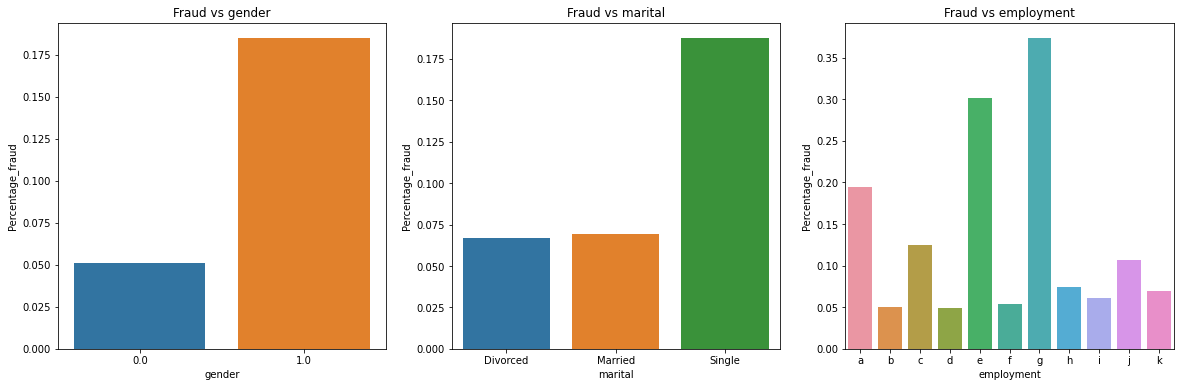

In [16]:
tmp1 = data[['fraud','gender']].groupby('gender').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'marital']].groupby('marital').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp3 = data[['fraud', 'employment']].groupby('employment').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 3, figsize=(20,6))

sns.barplot(x='gender', y='Percentage_fraud',data=tmp1, ax=ax[0])
sns.barplot(x='marital', y='Percentage_fraud',data=tmp2, ax=ax[1])
sns.barplot(x='employment', y='Percentage_fraud', data=tmp3, ax=ax[2])
ax[0].set_title('Fraud vs gender')
ax[1].set_title('Fraud vs marital')
ax[2].set_title('Fraud vs employment')
plt.show()

#### На графике "Fraud vs marital" наблюдаем, что если у пользователя семейное положение Single, то вероятность быть мошенником 2.5-3 раза выше, чем в  других случаях, а Married и Divorsed имеют одинаковую вероятность, поэтому сгруппируем их в один класс.
#### А на графике "Fraud vs employment" самые высокие вероятности у "g", "e" и "a" у остальных по сравнению ниже. Опять же сгруппируем их в один класс.

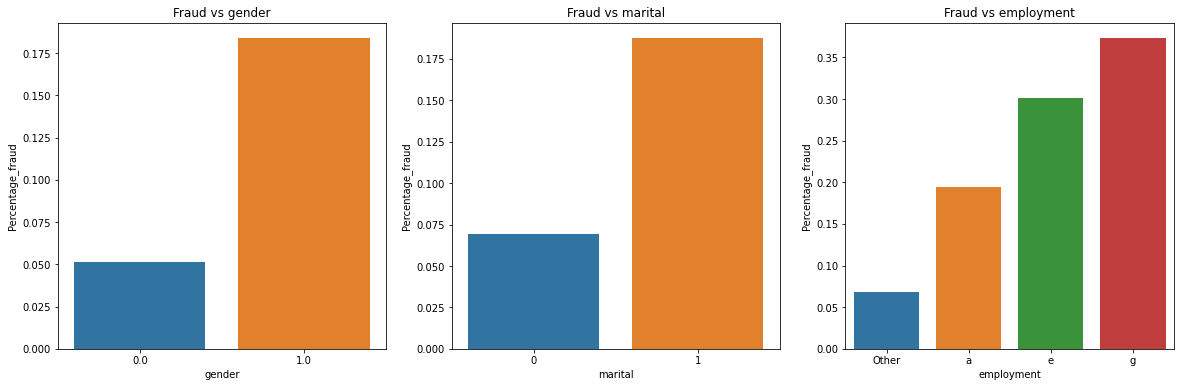

In [17]:
data.fillna({'gender': 1, 'marital': 'Single', 'employment': 'g'}, inplace=True)
top_employ = tmp3.sort_values('Percentage_fraud', ascending=False).head(3)['employment'].values

data.employment = data.employment.apply(lambda x:x if x in top_employ else 'Other')
data.marital = data.marital.map({'Single': 1, 'Married': 0, 'Divorced': 0})

tmp1 = data[['fraud','gender']].groupby('gender').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'marital']].groupby('marital').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp3 = data[['fraud', 'employment']].groupby('employment').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 3, figsize=(20,6))

sns.barplot(x='gender', y='Percentage_fraud',data=tmp1, ax=ax[0])
sns.barplot(x='marital', y='Percentage_fraud',data=tmp2, ax=ax[1])
sns.barplot(x='employment', y='Percentage_fraud', data=tmp3, ax=ax[2])
ax[0].set_title('Fraud vs gender')
ax[1].set_title('Fraud vs marital')
ax[2].set_title('Fraud vs employment')
plt.show()

In [18]:
data.pet.value_counts(normalize=True)

['Cat']                                                                                 0.269529
['No pets']                                                                             0.244781
['Dog', 'Cat']                                                                          0.134274
['Dog']                                                                                 0.086726
['Turtle', 'Dog', 'Cat']                                                                0.021504
                                                                                          ...   
['Monkey', 'Turtle', 'Bee', 'Bird']                                                     0.000014
['Turtle', 'Cat', 'Fish', 'Frog', 'Bird', 'Rabbit']                                     0.000014
['Monkey', 'Turtle', 'Dog', 'Fish', 'OTHER', 'Bee', 'Frog', 'Cow', 'Bird', 'Rabbit']    0.000014
['Monkey', 'Dog', 'Cat', 'Fish', 'Bee', 'Rabbit']                                       0.000014
['Cat', 'OTHER', 'Bee', 'Bird'

In [19]:
data.pet.fillna('["No pets"]', inplace=True)

pet_fraud = data[['fraud','pet']].groupby('pet').mean().sort_values('fraud', ascending=False)
pet_count = data.pet.value_counts().rename('number_of_list_this_pets')
g = pd.concat([pet_fraud, pet_count], axis=1)
g

,fraud,number_of_list_this_pets
"['Monkey', 'Turtle', 'Dog', 'Cat', 'Fish', 'OTHER', 'Frog']",1.0,1
"['Turtle', 'Dog', 'Cat', 'Fish', 'OTHER', 'Bee', 'Frog', 'Cow', 'Bird']",1.0,1
"['Monkey', 'Turtle', 'Dog', 'Fish', 'Frog', 'Cow', 'Bird', 'Rabbit']",1.0,1
"['Monkey', 'Turtle', 'Dog', 'Fish', 'OTHER', 'Bee', 'Frog', 'Cow', 'Bird', 'Rabbit']",1.0,1
"['Monkey', 'Dog', 'Bee', 'Frog', 'Bird', 'Rabbit']",1.0,1
...,...,...
"['Monkey', 'Dog', 'OTHER', 'Cow', 'Rabbit']",0.0,1
"['Monkey', 'Dog', 'OTHER', 'Bird', 'Rabbit']",0.0,1
"['Dog', 'Cat', 'Fish', 'OTHER', 'Bee', 'Cow', 'Bird', 'Rabbit']",0.0,1
"['Monkey', 'Dog', 'Frog', 'Bird']",0.0,1


#### Первый столбец указывает вероятность мошенничества, для отдельных разновидностей питомцев , второй столбец количество данной разновидности в общей выборке. 

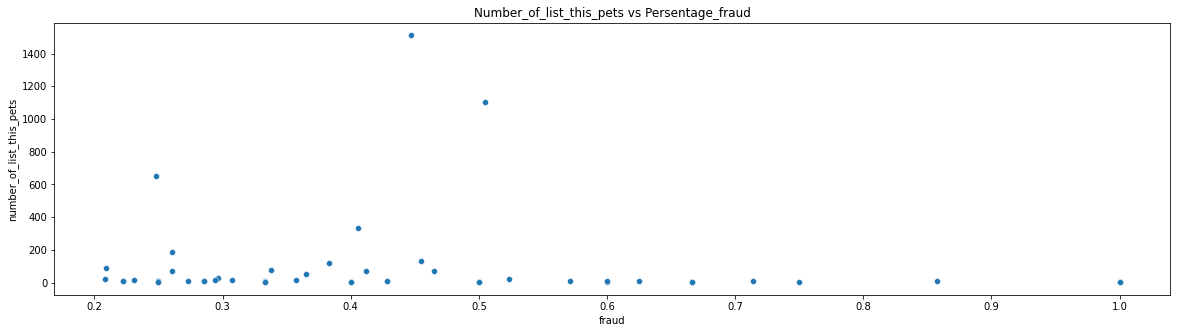

In [20]:
plt.figure(figsize=(20,5))
sns.scatterplot('fraud', 'number_of_list_this_pets', data=g[g.fraud>0.2]) \
    .set_title('Number_of_list_this_pets vs Persentage_fraud')
plt.show()

#### Первый столбец указывает вероятность мошенничества, для отдельных разновидностей питомцев , второй столбец количество данной разновидности в общей выборке. Нас интересуют только те у которых вероятность больше 20%.
#### Посмотрим на график зависимости этих переменных. Наблюдаем, что большинство имеют количество <400,  которое составляет примерно 0.5% общей выборки, а это очень мало, чтобы можно было отделить их , поэтому сгруппируем экземпляры имеющие количество больше 400 в разные классы, а остальные в один класс.

#### Также посмотрим на зависимость между вероятностью мошенничества и количеством  питомцев.

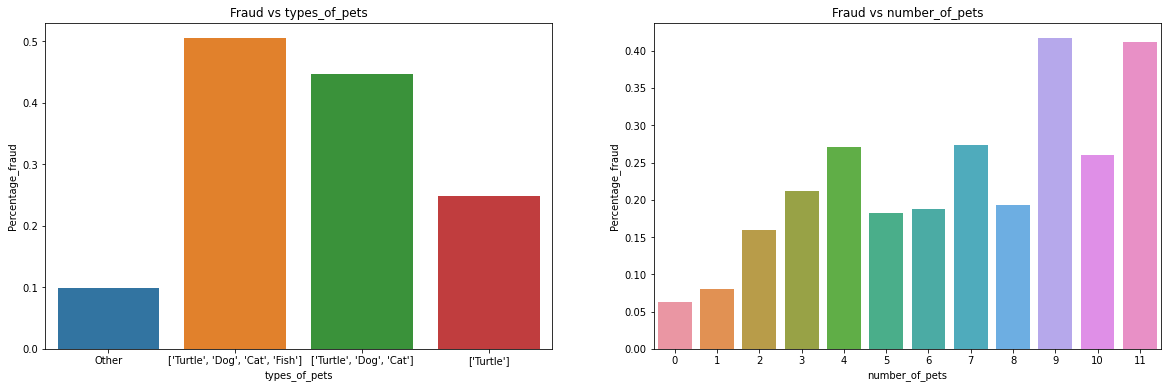

In [21]:
type_pets = g[(g.number_of_list_this_pets>400) & (g.fraud>0.2)].index

data['types_of_pets']=data.pet.apply(lambda x: x if x in type_pets else 'Other')
data['number_of_pets'] = data.pet.apply(lambda x: 0 if x=="['No pets']" else len(x.split()))

tmp1 = data[['fraud','types_of_pets']].groupby('types_of_pets').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'number_of_pets']].groupby('number_of_pets').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 2, figsize=(20,6))
sns.barplot(x='types_of_pets', y='Percentage_fraud',data=tmp1, ax=ax[0])
sns.barplot(x='number_of_pets', y='Percentage_fraud',data=tmp2, ax=ax[1])
ax[0].set_title('Fraud vs types_of_pets')
ax[1].set_title('Fraud vs number_of_pets')
plt.show()

In [22]:
data.drop(columns = ['number_of_pets','pet'], inplace=True)

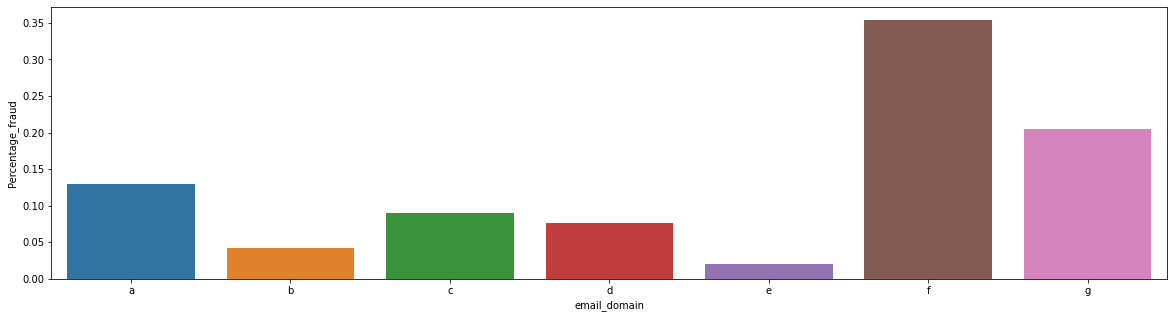

In [23]:
tmp = data[['fraud', 'email_domain']].groupby('email_domain').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

_, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='email_domain', y='Percentage_fraud',data=tmp)
plt.show()

In [24]:
data.email_domain = data.email_domain.apply(lambda x:x if x in ['g','f'] else 'Other')

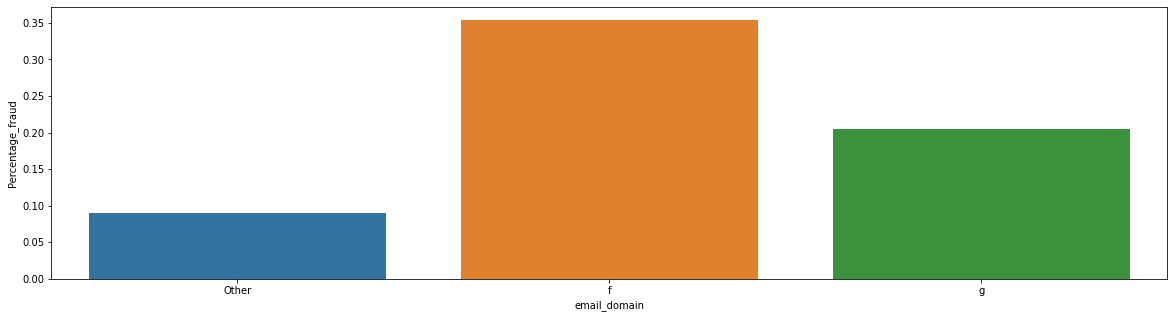

In [25]:
tmp = data[['fraud', 'email_domain']].groupby('email_domain').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

_, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='email_domain', y='Percentage_fraud',data=tmp)
plt.show()

#### Построим график между вероятностью мошенничества с определенными часами дня и дней недели регистрации.

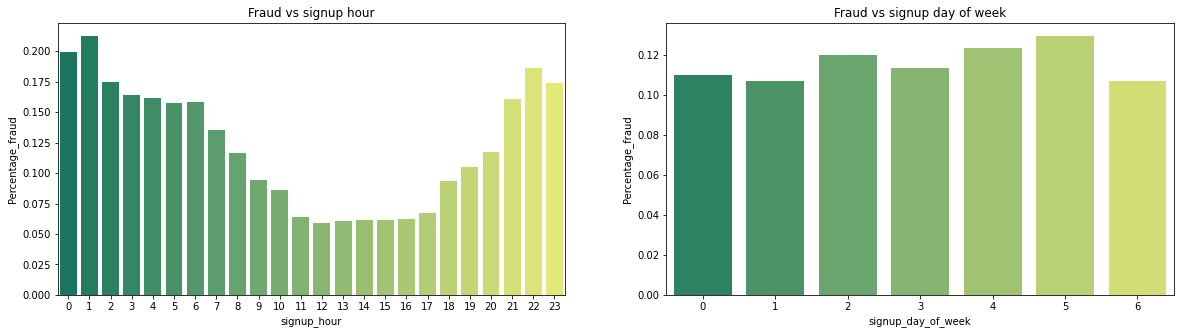

In [26]:
time_signup = data.signup_datetime.astype('datetime64[ns]')
data['signup_hour'] = time_signup.round('H').dt.hour
data['signup_day_of_week'] = time_signup.dt.dayofweek

tmp1 = data[['fraud','signup_hour']].groupby(by=['signup_hour']).mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'signup_day_of_week']].groupby(by=['signup_day_of_week']).mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.barplot(x=tmp1['signup_hour'], y=tmp1['Percentage_fraud'], palette='summer', ax=ax[0])
sns.barplot(x=tmp2['signup_day_of_week'], y=tmp2['Percentage_fraud'], palette='summer', ax=ax[1])
ax[0].set_title('Fraud vs signup hour')
ax[1].set_title('Fraud vs signup day of week')
plt.show()

#### Наблюдаем, что разные дни недели имеют почти одинаковую вероятность, поэтому этот признак мы отбросим, а разные часы влияют по разному. Сгруппируем их в три класса.

In [27]:
data.drop(['signup_day_of_week', 'signup_datetime'], axis=1, inplace=True)

In [28]:
for i in data.index:
    if data.signup_hour[i] in [0,1,21,22,23]:
        data.signup_hour[i] = '22:00-01:00'
    elif data.signup_hour[i] in [2,3,4,5,6,7]:
        data.signup_hour[i] = '2:00-7:00'
    else: data.signup_hour[i] = '8:00-20:00'

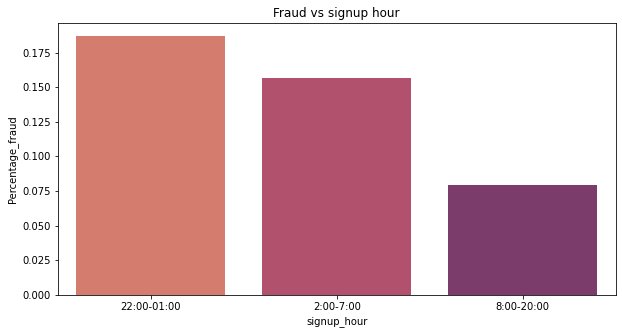

In [29]:
tmp = data[['fraud', 'signup_hour']].groupby(by=['signup_hour']).mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=tmp['signup_hour'], y=tmp['Percentage_fraud'], palette='flare') \
    .set_title('Fraud vs signup hour')
plt.show()

In [30]:
category = data.select_dtypes(include='object').columns
category

Index(['email_domain', 'employment', 'types_of_pets', 'signup_hour'], dtype='object')

In [31]:
dumies = pd.get_dummies(data[category])
fraud_prof = pd.concat([data, dumies], axis=1).drop(columns=category)
fraud_prof.head()

,user,fraud,ip_asn,gender,marital,email_domain_Other,email_domain_f,email_domain_g,employment_Other,employment_a,employment_e,employment_g,types_of_pets_Other,"types_of_pets_['Turtle', 'Dog', 'Cat', 'Fish']","types_of_pets_['Turtle', 'Dog', 'Cat']",types_of_pets_['Turtle'],signup_hour_22:00-01:00,signup_hour_2:00-7:00,signup_hour_8:00-20:00
0,1000000,0,11202,1.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
1,1000015,0,11202,1.0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
2,1000019,0,11202,1.0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1
3,1000045,0,11202,1.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
4,1000076,0,11202,0.0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1


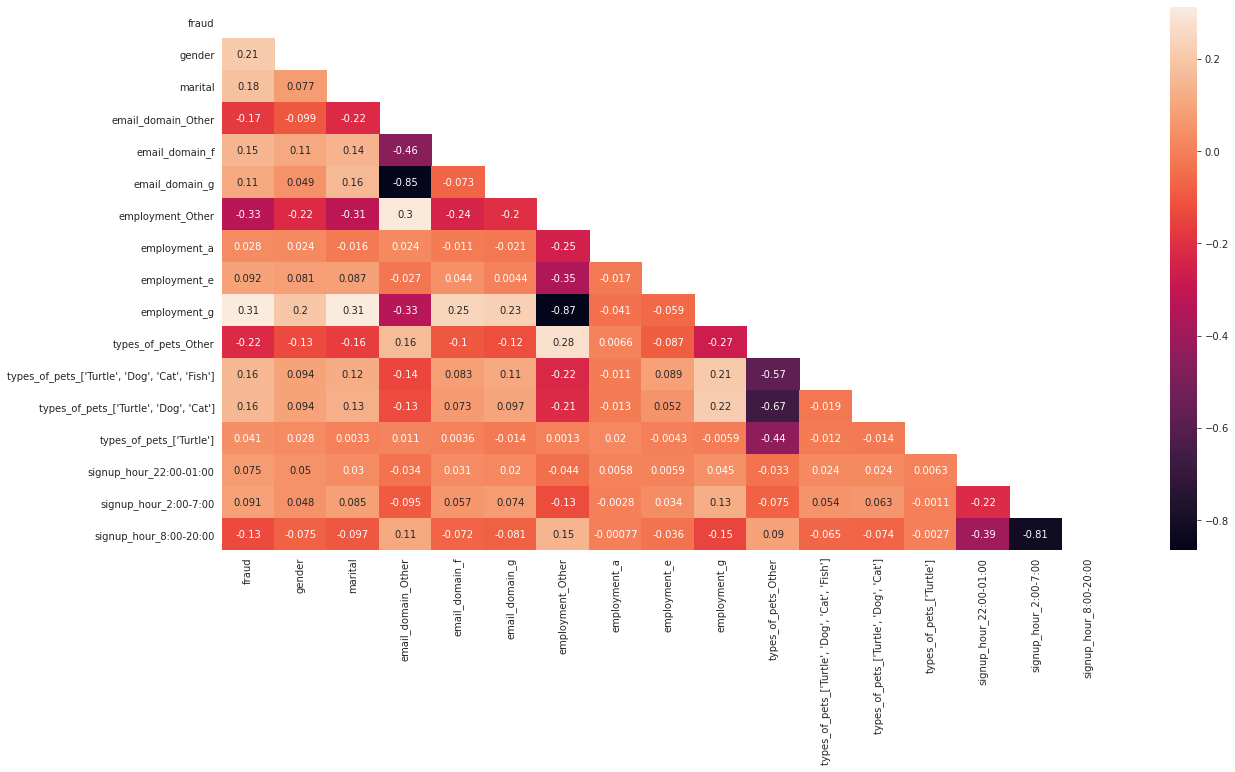

In [32]:
corr = fraud_prof.drop(columns=['user', 'ip_asn']).corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,10))
    ax = sns.heatmap(corr, mask=mask, annot=True)

In [39]:
fraud_prof.rename(columns = {fraud_prof.columns[13]: 'types_of_pets_1',
                            fraud_prof.columns[14]: 'types_of_pets_2',
                            fraud_prof.columns[15]: 'types_of_pets_3'}, inplace=True)

In [41]:
fraud_prof.to_csv('clean_profile.csv', index=False)
fraud_beh = pd.read_csv('fraud_behavior.csv')

merge_data = pd.merge(fraud_beh, fraud_prof, on='user', how='left')
merge_data.to_csv('merge.csv', index=False)